### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_96_layer1_filters_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [3]:
batch_size = 32
target_size = (512,384)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

holdout_generator = test_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [4]:
model=Sequential()

model.add(Conv2D(32, (7,7), strides=4, padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)


opt = keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 96, 32)       4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 96, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 47, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 128)       0

In [5]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch_96_layer1_filters.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 1000,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
61/61 [==============================] - 176s 3s/step - loss: 2.1041 - accuracy: 0.2714 - val_loss: 1.6907 - val_accuracy: 0.2301
Epoch 2/1000
61/61 [==============================] - 169s 3s/step - loss: 1.4815 - accuracy: 0.4111 - val_loss: 1.7037 - val_accuracy: 0.2537
Epoch 3/1000
61/61 [==============================] - 168s 3s/step - loss: 1.3571 - accuracy: 0.4880 - val_loss: 1.6536 - val_accuracy: 0.2773
Epoch 4/1000
61/61 [==============================] - 167s 3s/step - loss: 1.2798 - accuracy: 0.5320 - val_loss: 1.6107 - val_accuracy: 0.3746
Epoch 5/1000
61/61 [==============================] - 169s 3s/step - loss: 1.1707 - accuracy: 0.5839 - val_loss: 1.4524 - val_accuracy: 0.3923
Epoch 6/1000
61/61 [==============================] - 168s 3s/step - loss: 1.1009 - accuracy: 0.5905 - val_loss: 1.4332 - val_accuracy: 0.4248
Epoch 7/1000
61/61 [==============================] - 168s 3s/step - loss: 1.1560 - accuracy: 0.5670 - val_loss: 1.6525 - val_accuracy: 0.3009

In [6]:
score = model.evaluate(holdout_generator, verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.824701189994812


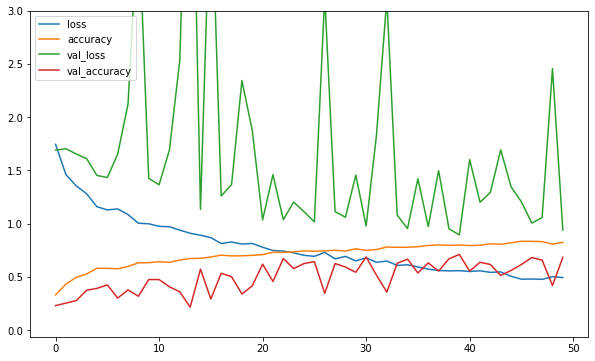

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=3)
plt.legend();

In [10]:
max(history.history['val_accuracy'])

0.7109144330024719